# Bibliotecas necessárias e funções.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization
from keras.layers import MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Sequential, model_from_json

import scipy.stats as stats
from statsmodels.formula.api import ols

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

In [2]:
def min_max(var):
  '''
  normalizador (min-max)
  '''
  vmin = var.min()
  vmax = var.max()
  return (var-vmin)/(vmax-vmin)

def r2_keras(y_true, y_pred):
  '''
  coeficiente de determinação (padrão keras)
  '''
  SS_res =  K.sum(K.square( y_true - y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Leitura dos dados

In [3]:
# caminho dos arquivos
path = '/content/drive/MyDrive/AGRO/data_new/'

# produtividade anual para cada município
rend = pd.read_csv(path+'rend_new.csv')   # dados sem tendência
rend.drop('Unnamed: 0', axis = 1, inplace = True)
print('yield data shape: ', rend.shape)
print()
rend.head()

yield data shape:  (50, 21)



,nivel,codigo_ibge,name,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,MU,4101051,Anahy,3190,2808.716202,2515.432405,3233.148607,2980.864809,2887.581011,2950.297214,...,2366.729618,3019.445820,3275.162023,3243.878225,3583.594427,3094.310630,3052.026832,2836.743034,2942.459236,2498.175439
1,MU,4102000,Assis Chateaubriand,2200,2531.432405,1927.864809,2762.297214,2825.729618,655.162023,3259.594427,...,852.459236,2875.891641,2517.324045,2540.756450,2597.188854,3075.621259,2520.053664,1171.486068,2602.918473,2084.350877
2,MU,4103057,Boa Vista da Aparecida,2750,2630.282766,2091.565531,3050.848297,3021.131063,3122.413829,3037.696594,...,1942.262126,3304.544892,2751.827657,2810.110423,2850.393189,2793.675955,2690.958720,2454.241486,3336.524252,2385.807018
3,MU,4103354,Braganey,2700,2577.728586,2101.457172,2990.185759,2949.914345,2377.642931,2782.371517,...,2376.828689,2786.557276,3041.285862,2976.014448,3030.743034,2988.471620,2419.200206,2605.928793,2658.657379,2263.385965
4,MU,4103453,Cafelândia,2663,2574.003096,2441.006192,2920.009288,3165.012384,2367.015480,2836.018576,...,2365.024768,3169.027864,3066.030960,3172.034056,2522.037152,3527.040248,2636.043344,2281.046440,2999.049536,2168.052632


In [4]:
# dados agroclimáticos de cada município
clima = pd.read_csv(path+'clima_final.csv')
clima = clima.set_index('data')
clima.index = pd.to_datetime(clima.index)

# adicionando atributos temporais
clima['ano'] = clima.index.year
clima['mes'] = clima.index.month
clima['dia_ano'] = clima.index.dayofyear
clima['dia_mes'] = clima.index.day
clima = clima.reset_index(drop = True)
clima.drop('Unnamed: 0', axis = 1, inplace = True)
print('climate data shape: ', clima.shape)
print()
clima.head()

climate data shape:  (109800, 19)



,T2M_RANGE,T2M_MIN,PRECTOTCORR,EVT,WS10M_RANGE,WS50M_RANGE,WS50M_MIN,WS2M_MAX,WS50M_MAX,PS,GWETTOP,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UVA,NDVI,codigo_ibge,ano,mes,dia_ano,dia_mes
0,17.62,8.75,0.00,4.2106,1.38,3.92,1.78,1.45,5.70,96.81,0.68,97.44,11.33,0.4362,4101051,2003,9,244,1
1,17.10,10.88,0.00,4.3950,2.24,4.41,0.45,1.63,4.86,96.90,0.67,90.73,10.27,0.4353,4101051,2003,9,245,2
2,16.97,11.58,0.09,4.4827,2.02,4.41,2.23,2.48,6.64,96.93,0.66,100.88,12.16,0.4347,4101051,2003,9,246,3
3,19.70,9.49,0.00,4.7675,2.22,2.76,3.99,2.73,6.75,96.79,0.66,109.57,13.60,0.4378,4101051,2003,9,247,4
4,17.42,13.87,0.00,4.9061,3.21,2.73,4.52,3.34,7.26,96.67,0.65,109.34,13.62,0.4339,4101051,2003,9,248,5


# Adicionando informação sobre ocorrências de El Niño e La Niña

In [5]:
# intensidade e códigos
enso = pd.DataFrame({'ano': np.arange(2003,2021),
                       'lanina_str': ['N','N','LA1','N','LA3','LA1','N','LA3',
                                      'LA2','N','N','N','N','LA1','LA1','N',
                                      'N','LA2'],
                       'elnino_str': ['N','EL1','N','EL1','N','N','EL2','N','N',
                                      'N','N','EL1','EL4','N','N','EL1',
                                      'N','N'],
                       'lanina_cod': np.array([0,0,1,0,3,1,0,3,2,
                                               0,0,0,0,1,1,0,0,2]),
                       'elnino_cod': np.array([0,1,0,1,0,0,2,0,0,
                                               0,0,1,4,0,0,1,0,0])})

# normalizando valores (não foi utilizado)
enso['lanina_cod_norm'] = min_max(enso['lanina_cod'])
enso['elnino_cod_norm'] = min_max(enso['elnino_cod'])

# one-hot encoding
dummies = pd.get_dummies(enso[['lanina_str','elnino_str']])
enso[dummies.columns] = dummies 
enso.head()

,ano,lanina_str,elnino_str,lanina_cod,elnino_cod,lanina_cod_norm,elnino_cod_norm,lanina_str_LA1,lanina_str_LA2,lanina_str_LA3,lanina_str_N,elnino_str_EL1,elnino_str_EL2,elnino_str_EL4,elnino_str_N
0,2003,N,N,0,0,0.000000,0.00,0,0,0,1,0,0,0,1
1,2004,N,EL1,0,1,0.000000,0.25,0,0,0,1,1,0,0,0
2,2005,LA1,N,1,0,0.333333,0.00,1,0,0,0,0,0,0,1
3,2006,N,EL1,0,1,0.000000,0.25,0,0,0,1,1,0,0,0
4,2007,LA3,N,3,0,1.000000,0.00,0,0,1,0,0,0,0,1


# Separação dos dados de treino e teste e pré-processamento.

In [6]:
# seleção aleatória dos municípios das bases de treino e teste
n_feats = 25
np.random.seed(42)
munic_teste = np.random.choice(clima['codigo_ibge'].unique(),
                               10,replace = False)

clima_test = clima[clima['codigo_ibge'].isin(munic_teste)]
clima_train = clima[~clima['codigo_ibge'].isin(munic_teste)]

x_train = np.zeros((720, 122, n_feats, 1))
x_test = np.zeros((180, 122, n_feats, 1))

y_train = np.zeros((720,1))
y_test = np.zeros((180,1))

ano = clima_train['ano'].unique()
cod_train = clima_train['codigo_ibge'].unique()
cod_test = clima_test['codigo_ibge'].unique()

In [7]:
cols = dummies.columns
# pré-processamento (dados de treinamento)
k = 0

for i in cod_train:
  for j in ano:
    aux = clima_train.loc[(clima_train['ano']==j) & 
                          (clima_train['codigo_ibge']==i)].drop(['ano',
                                                                 'codigo_ibge'],
                                                                 axis = 1)
    aux_norm = aux.apply(min_max, axis = 0)
    aux_norm[cols] = np.tile(enso.loc[enso['ano']==j, cols].values,(122,1))
    x_train[k] = np.array(aux_norm).reshape((122,n_feats,1))
    y_train[k] = np.array(rend[rend['codigo_ibge']==i][str(j+1)])
    k = k+1

# pré-processamento (dados de teste)
k = 0

for i in cod_test:
  for j in ano:
    aux = clima_test.loc[(clima_test['ano']==j) & 
                         (clima_test['codigo_ibge']==i)].drop(['ano',
                                                               'codigo_ibge'],
                                                               axis = 1)
    aux_norm = aux.apply(min_max, axis = 0)
    aux_norm[cols] = np.tile(enso.loc[enso['ano']==j, cols].values,(122,1))
    x_test[k] = np.array(aux_norm).reshape((122,n_feats,1))
    y_test[k] = np.array(rend[rend['codigo_ibge']==i][str(j+1)])
    k = k+1

In [8]:
# normalização dos dados de produtividade
vmin = y_train.min()
vmax = y_train.max()

y_train_norm = (y_train - vmin)/(vmax - vmin)
y_test_norm = (y_test - vmin)/(vmax - vmin)

In [9]:
# verificando as dimensões
print('X train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (720, 122, 25, 1)
y train shape:  (720, 1)
X test shape:  (180, 122, 25, 1)
y test shape:  (180, 1)


# Seleção da arquitetura CNN

In [ ]:
def modelo():
  '''
  adicione como parâmetro desta função os parâmetros a serem alterados
  na rede, por exemplo, taxa de dropout
  '''
  np.random.seed(42)
  tf.random.set_seed(42)

  CNN = Sequential()
  CNN.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', 
                 input_shape=(122,25,1)))
  CNN.add(MaxPooling2D(padding='same'))
  
  CNN.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
  CNN.add(MaxPooling2D(padding='same'))

  CNN.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  CNN.add(MaxPooling2D(padding='same'))
  
  CNN.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
  CNN.add(MaxPooling2D(padding='same'))
  
  CNN.add(GlobalMaxPooling2D())
  # CNN.add(Flatten())
  CNN.add(Dense(100, activation='relu', name = 'my_dense'))
  CNN.add(Dropout(0.25))

  CNN.add(Dense(1, activation='linear'))

  return CNN

In [13]:
# decaimento de learning rate
def scheduler(epoch, lr):
  '''
  função que controla o decaimento da taxa de aprendizado
  '''
  if (epoch % 5 == 0): print("Época %04d - learning rate %.8f" % (epoch, lr))
  if (epoch+1 < 5):
    return lr
  else:
    return np.round(lr * tf.math.exp(-0.01),9)

In [ ]:
# implementação do 10-fold cross validation
# alterar parâmetros da otimização quando necessário, por exemplo, batchsize

# monitor de parada precoce
callbackes = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=15, verbose=0, mode='min',
                           restore_best_weights=True)
# monitor de decaimento de taxa de aprendizado
callbacklr = LearningRateScheduler(scheduler)

X = x_train
Y = y_train_norm

# define 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cvscores1 = []
cvscores2 = []
cvscores3 = []

# alterar optimizer e callbacks de acordo com o esquema adotado
for train, test in kfold.split(X, Y):
  model = modelo()
  
  model.compile(loss='mean_squared_error',
                # optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                optimizer=keras.optimizers.SGD(learning_rate=0.01, 
                                               momentum=0.9),
                metrics = ['mae', r2_keras])
  
  hist = model.fit(X[train], Y[train], 
                   epochs=500, 
                   batch_size=90,
                   validation_data=(X[test], Y[test]),
                   callbacks=[callbackes],
                  #  callbacks=[callbacklr,callbackes],
                   verbose=0)
  
  scores = model.evaluate(X[test], Y[test], verbose=0)
  print(model.metrics_names[0], np.round(scores[0],4), 
        model.metrics_names[1], np.round(scores[1],4), 
        model.metrics_names[2], np.round(scores[2],4),
        'epochs', len(hist.history['loss']))
  cvscores1.append(scores[0])
  cvscores2.append(scores[1])
  cvscores3.append(scores[2])
 
print("%.2f (+/- %.2f)" % (np.mean(cvscores1), np.std(cvscores1)))
print("%.2f (+/- %.2f)" % (np.mean(cvscores2), np.std(cvscores2)))
print("%.2f (+/- %.2f)" % (np.mean(cvscores3), np.std(cvscores3)))

# Treinamento Final

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

CNN = Sequential()
CNN.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', 
               input_shape=(122,25,1)))
CNN.add(MaxPooling2D(padding='same'))
  
CNN.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
CNN.add(MaxPooling2D(padding='same'))

CNN.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
CNN.add(MaxPooling2D(padding='same'))
  
CNN.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
CNN.add(MaxPooling2D(padding='same'))
  
CNN.add(GlobalMaxPooling2D(name = 'my_dense'))
# CNN.add(Flatten(name = 'my_dense'))
CNN.add(Dense(100, activation='relu'))
CNN.add(Dropout(0.25))

CNN.add(Dense(1, activation='linear'))

# model compiling
CNN.compile(loss='mean_squared_error',
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
            # optimizer=keras.optimizers.Adam(),
            metrics = ['mae', r2_keras])

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 122, 25, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 7, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 31, 7, 128)        73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 4, 128)      

In [19]:
callbackes = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=15, verbose=0, mode='min', 
                           restore_best_weights=True)
callbacklr = LearningRateScheduler(scheduler)

# treinamento
# desativar callbacks e validation_split no treinamento final
epochs = 450
batch_size = 90

histCNN = CNN.fit(x_train, y_train_norm,
                  epochs = epochs,
                  batch_size = batch_size,
                  # validation_split=0.1,   
                  callbacks=[callbackes],
                  # callbacks=[callbacklr,callbackes],
                  verbose = 2)

Epoch 1/450
8/8 - 10s - loss: 0.1393 - mae: 0.3077 - r2_keras: -3.8554e+00 - val_loss: 0.0775 - val_mae: 0.2223 - val_r2_keras: -1.7254e+00 - 10s/epoch - 1s/step
Epoch 2/450
8/8 - 7s - loss: 0.0538 - mae: 0.1916 - r2_keras: -8.3680e-01 - val_loss: 0.0430 - val_mae: 0.1854 - val_r2_keras: -5.1078e-01 - 7s/epoch - 819ms/step
Epoch 3/450
8/8 - 9s - loss: 0.0384 - mae: 0.1529 - r2_keras: -2.9544e-01 - val_loss: 0.0337 - val_mae: 0.1237 - val_r2_keras: -1.8451e-01 - 9s/epoch - 1s/step
Epoch 4/450
8/8 - 9s - loss: 0.0334 - mae: 0.1359 - r2_keras: -1.0164e-01 - val_loss: 0.0281 - val_mae: 0.1312 - val_r2_keras: 0.0141 - 9s/epoch - 1s/step
Epoch 5/450
8/8 - 9s - loss: 0.0332 - mae: 0.1476 - r2_keras: -9.4899e-02 - val_loss: 0.0276 - val_mae: 0.1293 - val_r2_keras: 0.0301 - 9s/epoch - 1s/step
Epoch 6/450
8/8 - 7s - loss: 0.0319 - mae: 0.1362 - r2_keras: -5.0990e-02 - val_loss: 0.0277 - val_mae: 0.1169 - val_r2_keras: 0.0257 - 7s/epoch - 844ms/step
Epoch 7/450
8/8 - 8s - loss: 0.0304 - mae: 0.13

# Verificação de métricas

In [20]:
y_pred = CNN.predict(x_test)

y_train = CNN.predict(x_train)

print('MSE (treino): ',mean_squared_error(y_train_norm, y_train))
print('MAE (treino): ',mean_absolute_error(y_train_norm, y_train))
print('R2  (treino): ',r2_score(y_train_norm, y_train))
print()
print()
print('MSE (teste): ',mean_squared_error(y_test_norm, y_pred))
print('MAE (teste): ',mean_absolute_error(y_test_norm, y_pred))
print('R2  (teste): ',r2_score(y_test_norm, y_pred))

23/23 [==============================] - 2s 70ms/step
MSE (treino):  0.00917069497276414
MAE (treino):  0.07385350438425725
R2  (treino):  0.7003636381080982


MSE (teste):  0.00922573953349077
MAE (teste):  0.07590829304482724
R2  (teste):  0.6759499372900867


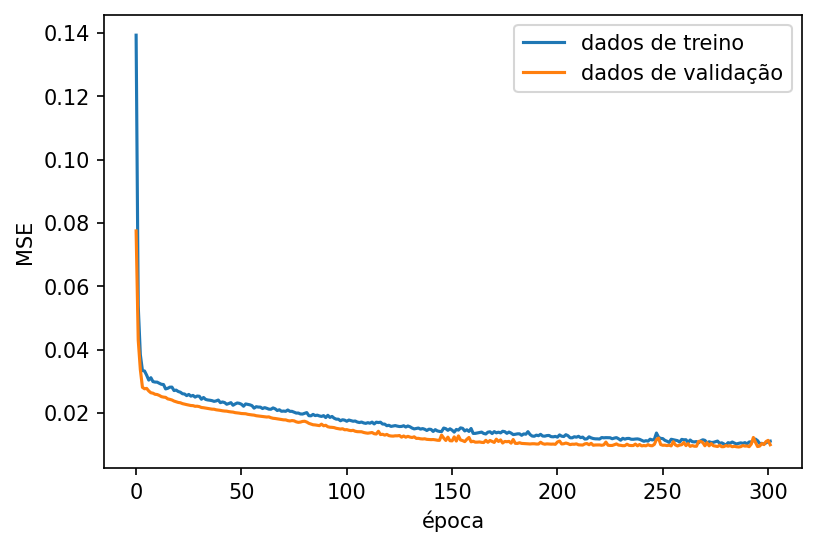

In [21]:
# Checando a convergência (em termos do MSE)
# Este gráfico só pode ser gerado quando for utilizado dados de validação
fig = plt.figure(dpi = 150)
plt.plot(histCNN.history['loss'])
plt.plot(histCNN.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('época')
plt.legend(['dados de treino', 'dados de validação'], loc='upper right')
plt.show()

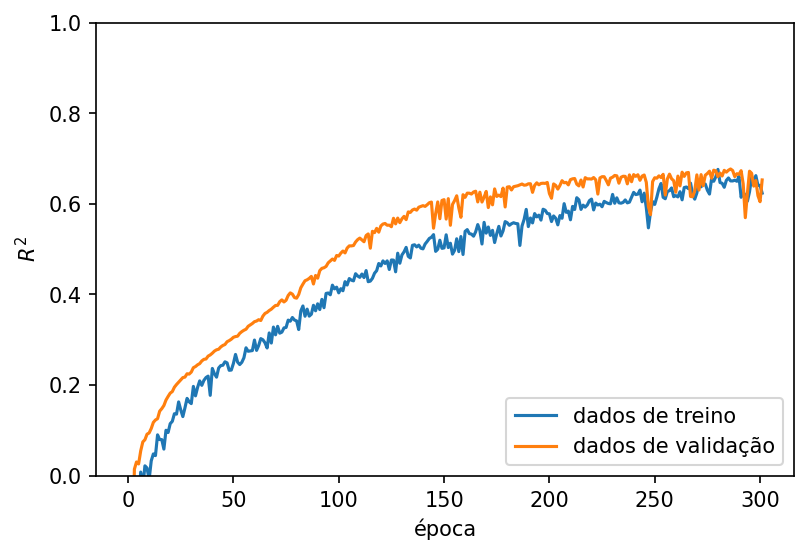

In [22]:
# Checando a convergência (em termos do coeficiente de determinação)
# Este gráfico só pode ser gerado quando for utilizado dados de validação
fig = plt.figure(dpi = 150)
plt.plot(histCNN.history['r2_keras'])
plt.plot(histCNN.history['val_r2_keras'])
plt.ylabel('$R^2$')
plt.xlabel('época')
plt.legend(['dados de treino', 'dados de validação'], loc='lower right')
plt.ylim(0,1)
plt.show()

In [ ]:
# Salvando o modelo ajustado (sem dados de validação e parada precoce)
# model_json = CNN.to_json()
# with open("CNN.json", "w") as json_file:
#     json_file.write(model_json)
# CNN.save_weights("model.h5")

In [23]:
# Código para carregar o modelo salvo na célula anterior
json_file = open(path+'CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(path+"model.h5")
 
# compilando o modelo carregado
loaded_model.compile(loss='mean_squared_error',
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
            metrics = ['mae', r2_keras])

In [24]:
# testando
y_pred = loaded_model.predict(x_test)
y_train = loaded_model.predict(x_train)

print('MSE (treino): ',mean_squared_error(y_train_norm, y_train))
print('MAE (treino): ',mean_absolute_error(y_train_norm, y_train))
print('R2  (treino): ',r2_score(y_train_norm, y_train))
print()
print()
print('MSE (teste): ',mean_squared_error(y_test_norm, y_pred))
print('MAE (teste): ',mean_absolute_error(y_test_norm, y_pred))
print('R2  (teste): ',r2_score(y_test_norm, y_pred))

23/23 [==============================] - 2s 70ms/step
MSE (treino):  0.008500494674893617
MAE (treino):  0.07080337318324124
R2  (treino):  0.722261256509887


MSE (teste):  0.008759024212499257
MAE (teste):  0.07503090282549547
R2  (teste):  0.6923431086435545


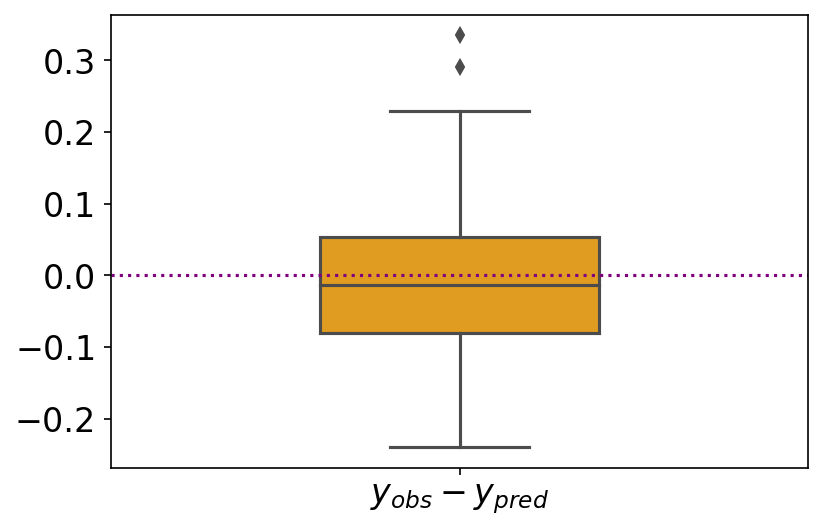

In [25]:
# box-plot dos desvios (predito x observado) - Figura 35
df_diff = pd.DataFrame(data = y_test_norm-y_pred, 
                       columns = ['$y_{obs}-y_{pred}$'])
plt.figure(dpi = 150)
sns.boxplot(data = df_diff, width = 0.4, color='orange')
plt.axhline(0, c='purple', ls = 'dotted')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

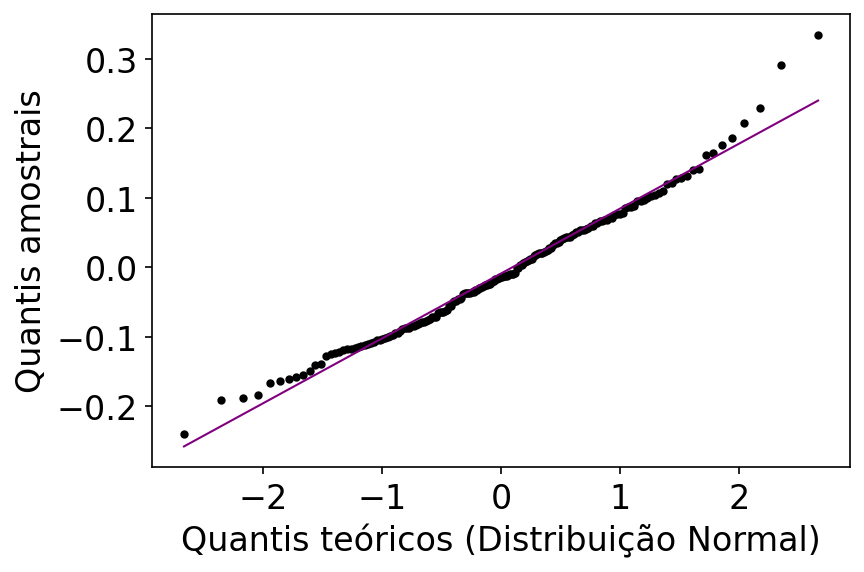

In [26]:
# gráfico de quantis normais dos desvios - Figura 35
res = y_test_norm-y_pred

fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111)

stats.probplot(res.reshape(-1), dist="norm", plot=plt)

ax.get_lines()[0].set_markerfacecolor('black')
ax.get_lines()[0].set_markeredgecolor('black')
ax.get_lines()[0].set_markersize(3)

ax.get_lines()[1].set_linewidth(1)
ax.get_lines()[1].set_color('purple')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('')
plt.xlabel('Quantis teóricos (Distribuição Normal)', fontsize = 16)
plt.ylabel('Quantis amostrais', fontsize = 16)
plt.show()

In [27]:
# desvio padrão dos desvios (resposta normalizada)
np.std(y_test_norm-y_pred)

0.09315595362218064

In [28]:
# desvio padrão dos desvios (dados na escala real)
y_pred_real = y_pred*(vmax-vmin)+vmin
np.std(y_test - y_pred_real)

344.49351229363566

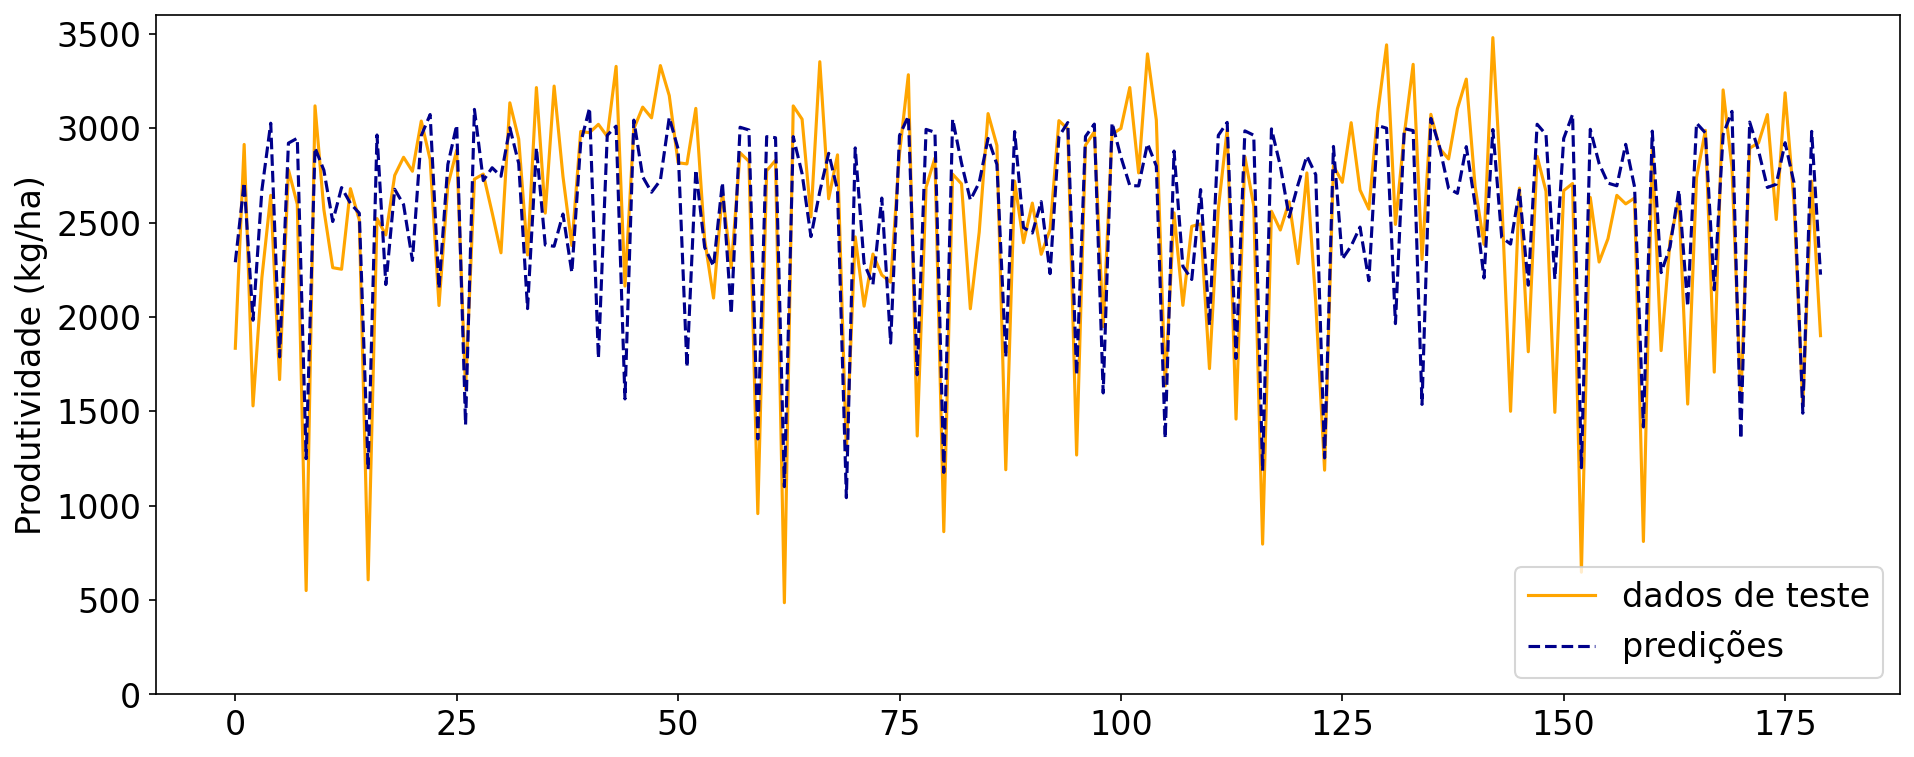

In [29]:
# gráfico de linhas - Figura 37
fig = plt.figure(figsize=(15,6), dpi=150)
plt.plot(y_test, label = 'dados de teste', color = 'orange')
plt.plot(y_pred_real,'--', label = 'predições', color = 'darkblue')
plt.legend(loc = 'lower right', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,3600)
plt.ylabel('Produtividade (kg/ha)', fontsize = 16)
plt.show()

In [30]:
# regressão linear simples entre valores preditos e observados
df = pd.DataFrame({'Test': y_test.reshape(-1), 'Pred': y_pred_real.reshape(-1)})

mod_fit = ols('Test ~ Pred', data=df).fit()
print(mod_fit.summary())

x_new = np.linspace(500,3500,100)

dt = mod_fit.get_prediction(pd.DataFrame({'Pred': x_new}))
dt = dt.summary_frame(alpha = 0.05)
y_prd = dt['mean'].values
yprd_ci_lower = dt['obs_ci_lower'].values
yprd_ci_upper = dt['obs_ci_upper'].values

                            OLS Regression Results                            
Dep. Variable:                   Test   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     406.0
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           8.50e-48
Time:                        21:47:59   Log-Likelihood:                -1307.0
No. Observations:                 180   AIC:                             2618.
Df Residuals:                     178   BIC:                             2624.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.0039    128.025     -0.133      0.8

(400.0, 3600.0)

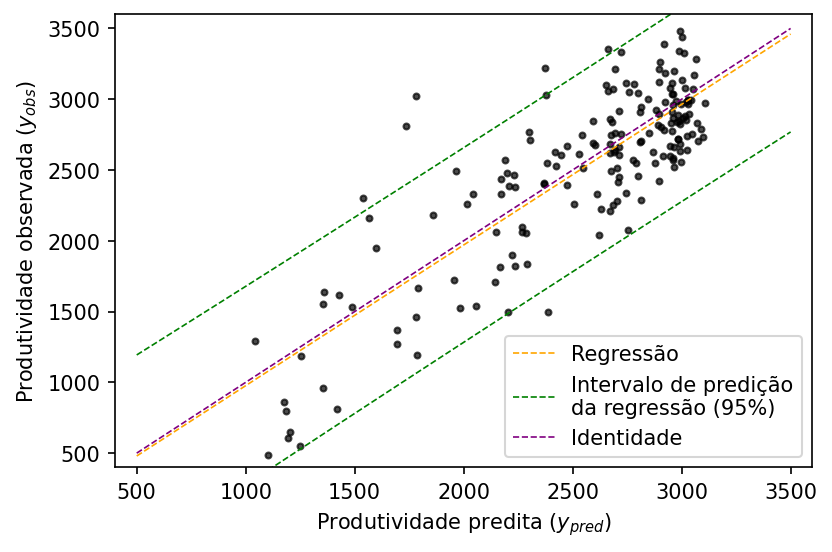

In [31]:
# Figura 36
plt.figure(dpi = 150)

plt.scatter(y_pred_real, y_test, s=8, c = 'black', alpha = 0.7)

plt.xlabel('Produtividade predita ($y_{pred}$)')
plt.ylabel('Produtividade observada ($y_{obs}$)')

plt.plot(x_new, y_prd, linestyle='--', linewidth='0.8', 
         color = 'orange', label='Regressão')
plt.plot(x_new, yprd_ci_lower, linestyle='--', linewidth='0.8', color = 'green',
         label = 'Intervalo de predição\nda regressão (95%)')
plt.plot(x_new, yprd_ci_upper, linestyle='--', linewidth='0.8', color = 'green')

plt.plot([500,3500],[500,3500], linestyle='--', color = 'purple', 
         label='Identidade', linewidth='0.8')

plt.legend(loc='lower right')
plt.xlim(400,3600)
plt.ylim(400,3600)

In [ ]:
# %%capture
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
# %%capture
# !jupyter nbconvert --to pdf /content/modeling.ipynb